In [1]:
import pandas as pd
data=pd.read_csv('monthly_data.csv')
data.head()

,ticker,date,open,high,low,close,volume,outstanding_share,turnover,pe,pe_ttm,pb,ps,ps_ttm,dv_ratio,dv_ttm,total_mv,qfq_factor
0,sh600000,31-05-2022,8.03,8.08,7.71,7.86,135071971,2.935217e+10,0.004602,4.36048,4.30440,0.40220,1.21018,1.20710,6.09634,6.09634,2.311190e+07,1.0
1,sh600006,31-05-2022,4.58,5.00,4.56,4.83,77841235,2.000000e+09,0.038921,25.38284,43.42806,1.15922,0.60682,0.62186,1.76174,1.76174,9.436000e+05,1.0
2,sh600009,31-05-2022,49.13,51.33,45.75,47.67,83690662,1.093476e+09,0.076536,NaN,NaN,3.44836,24.97222,25.14398,0.00000,NaN,9.309136e+06,1.0
3,sh600012,31-05-2022,7.28,7.40,7.03,7.06,27038260,1.165600e+09,0.023197,7.83208,7.56278,1.00538,3.02454,2.93558,3.21698,3.21698,1.185906e+06,1.0
4,sh600015,31-05-2022,5.44,5.46,5.21,5.27,141224157,1.282269e+10,0.011014,3.45860,3.41922,0.33568,0.84902,0.84560,5.69040,5.69040,8.139841e+06,1.0


In [2]:
#Initial Exporatory Data Analysis

# Display basic information
print("Dataset Info:")
print(data.info())

print("\nDataset Summary:")
print(data.describe())

print("\nFirst Five Rows:")
print(data.head())

# Check for missing values
print("\nMissing Values:")
print(data.isnull().sum())

# Check for duplicate rows
print("\nNumber of Duplicate Rows:", data.duplicated().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35426 entries, 0 to 35425
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ticker             35426 non-null  object 
 1   date               35426 non-null  object 
 2   open               35426 non-null  float64
 3   high               35426 non-null  float64
 4   low                35426 non-null  float64
 5   close              35426 non-null  float64
 6   volume             35426 non-null  int64  
 7   outstanding_share  35426 non-null  float64
 8   turnover           35426 non-null  float64
 9   pe                 32122 non-null  float64
 10  pe_ttm             30300 non-null  float64
 11  pb                 35131 non-null  float64
 12  ps                 35426 non-null  float64
 13  ps_ttm             35386 non-null  float64
 14  dv_ratio           33108 non-null  float64
 15  dv_ttm             22645 non-null  float64
 16  total_mv

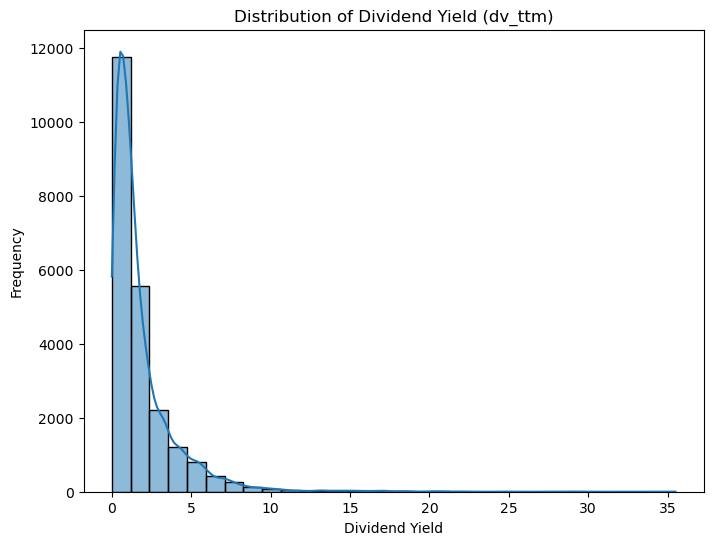

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Check the distribution of the target variable (dividend yield)
plt.figure(figsize=(8, 6))
sns.histplot(data['dv_ttm'], kde=True, bins=30)
plt.title('Distribution of Dividend Yield (dv_ttm)')
plt.xlabel('Dividend Yield')
plt.ylabel('Frequency')
plt.show()

In [4]:
#Add/Modify New Features and define target variable 'is_dividend_payer'

# Sort the dataset by ticker and date
data['date'] = pd.to_datetime(data['date'], format='%d-%m-%Y')
data.sort_values(by=['ticker', 'date'], inplace=True)
data['dv_ttm'].fillna(0, inplace=True)

# Create lagged features for key financial metrics
lag_features = ['pe', 'pb', 'ps', 'turnover', 'dv_ttm']
for feature in lag_features:
    data[f'{feature}_lag1'] = data.groupby('ticker')[feature].shift(1)
    data[f'{feature}_lag2'] = data.groupby('ticker')[feature].shift(2)


# Create the target variable (binary: dividend payer or not)
data['is_dividend_payer'] = (data['dv_ttm'] > 0).astype(int)

# Drop original 'dv_ttm' column 
data.drop(columns=['dv_ttm'], inplace=True)

#Adding new features to take the ticker into account
data['avg_pe_per_ticker'] = data.groupby('ticker')['pe'].transform('mean')
data['dividend_frequency'] = data.groupby('ticker')['is_dividend_payer'].transform('mean')

In [5]:
#Handle Missing Values

# Fill missing values with the mean for each ticker or 0 if all values are missing
financial_ratios = ['pe', 'pb', 'ps', 'turnover','pe_ttm','dv_ratio','ps_ttm'] + [f'{feature}_lag1' for feature in lag_features]+[f'{feature}_lag2' for feature in lag_features]
for col in financial_ratios:
    data[col] = data.groupby('ticker')[col].transform(lambda x: x.fillna(x.mean()))
    data[col].fillna(0, inplace=True)  # If all values are missing for a ticker
    
data.isnull().sum()

ticker                0
date                  0
open                  0
high                  0
low                   0
close                 0
volume                0
outstanding_share     0
turnover              0
pe                    0
pe_ttm                0
pb                    0
ps                    0
ps_ttm                0
dv_ratio              0
total_mv              0
qfq_factor            0
pe_lag1               0
pe_lag2               0
pb_lag1               0
pb_lag2               0
ps_lag1               0
ps_lag2               0
turnover_lag1         0
turnover_lag2         0
dv_ttm_lag1           0
dv_ttm_lag2           0
is_dividend_payer     0
avg_pe_per_ticker     0
dividend_frequency    0
dtype: int64

In [6]:
#Handle Multicollinearity

from statsmodels.stats.outliers_influence import variance_inflation_factor

columns_to_exclude = ['ticker', 'date', 'qfq_factor']
numerical_data = data.drop(columns=columns_to_exclude)

# Calculate VIF for all numerical columns
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data['Feature'] = df.columns
    vif_data['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

# Compute VIF
vif = calculate_vif(numerical_data)
print("Initial VIF Values:")
print(vif)

# Drop features iteratively based on high VIF
threshold = 5  
while vif['VIF'].max() > threshold:
    feature_to_drop = vif.sort_values('VIF', ascending=False)['Feature'].iloc[0]
    print(f"Dropping '{feature_to_drop}' with VIF = {vif['VIF'].max()}")
    numerical_data.drop(columns=[feature_to_drop], inplace=True)
    vif = calculate_vif(numerical_data)

print("\nFinal VIF Values:")
print(vif)


Initial VIF Values:
               Feature         VIF
0                 open  211.402904
1                 high  265.443188
2                  low  218.381214
3                close  230.673563
4               volume    1.818537
5    outstanding_share    2.551729
6             turnover    5.056690
7                   pe   10.315686
8               pe_ttm    1.016170
9                   pb    9.644205
10                  ps    8.094376
11              ps_ttm    3.371415
12            dv_ratio    5.455644
13            total_mv    2.434711
14             pe_lag1   21.722626
15             pe_lag2   10.345052
16             pb_lag1   18.896316
17             pb_lag2   10.247294
18             ps_lag1   12.950634
19             ps_lag2    6.591104
20       turnover_lag1    5.863679
21       turnover_lag2    4.284219
22         dv_ttm_lag1   13.342082
23         dv_ttm_lag2   12.613768
24   is_dividend_payer    5.329673
25   avg_pe_per_ticker    1.901318
26  dividend_frequency    6.745574


In [7]:
data['is_dividend_payer'].value_counts()


1    22645
0    12781
Name: is_dividend_payer, dtype: int64

In [8]:
#Calculate appropriate date to split data into training and testing set

# Define the split percentage for training data
train_percentage = 0.8

# Calculate the split date based on the percentage
split_date = data['date'].min() + (data['date'].max() - data['date'].min()) * train_percentage
print("Recommended Split Date:", split_date)


Recommended Split Date: 2018-12-12 04:48:00


In [9]:
#Split into training and testing set

train_data = data[data['date'] < split_date]
test_data = data[data['date'] >= split_date]

# Separate features and target
exclude_columns = ['date', 'is_dividend_payer','ticker']
X_train = train_data.drop(columns=exclude_columns)
y_train = train_data['is_dividend_payer']

X_test = test_data.drop(columns=exclude_columns)
y_test = test_data['is_dividend_payer']



In [10]:
pip install xgboost lightgbm catboost


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 41.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 97.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 131.7 MB/s eta 0:00:0000:0100:01
  Created wheel for lightgbm: filename=lightgbm-4.5.0-py3-none-linux_x86_64.whl size=2738816 sha256=6d55d5fede81062c745834cf16ab06c84b31743af858710704b50590e64c6aa6
  Stored in directory: /home/ec2-user/.cache/pip/wheels/7c/16/bf/61bc6295609c0752bc0f5b774a41f3413bca3afe3a73d2e47d
Successfully built lightgbm
Note: you may need to restart the kernel to use updated packages.


In [11]:
#Train Models - LightGBM, XGBoost and CatBoost

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score

# Initialize models
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
lgb_model = lgb.LGBMClassifier(random_state=42)
cat_model = CatBoostClassifier(random_state=42, verbose=0)

# Train models
xgb_model.fit(X_train, y_train)
lgb_model.fit(X_train, y_train)
cat_model.fit(X_train, y_train)

# Make predictions
models = {'XGBoost': xgb_model, 'LightGBM': lgb_model, 'CatBoost': cat_model}
results = {}

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC
    
    # Store metrics
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba),
        'Classification Report': classification_report(y_test, y_pred, output_dict=True),
    }


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [19:53:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 17591, number of negative: 10522
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001899 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6690
[LightGBM] [Info] Number of data points in the train set: 28113, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.625725 -> initscore=0.513919
[LightGBM] [Info] Start training from score 0.513919


In [12]:
#Compare the results of the three models
import pandas as pd
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score

# Initialize a dictionary to store results
results = {}

# Evaluate and store metrics for each model
for name, model in models.items():
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    report = classification_report(y_test, y_pred, output_dict=True)
    precision_0 = report['0']['precision']
    recall_0 = report['0']['recall']
    f1_0 = report['0']['f1-score']
    precision_1 = report['1']['precision']
    recall_1 = report['1']['recall']
    f1_1 = report['1']['f1-score']

    # Store results
    results[name] = {
        'Accuracy': accuracy,
        'ROC-AUC': roc_auc,
        'Precision (0)': precision_0,
        'Recall (0)': recall_0,
        'F1-Score (0)': f1_0,
        'Precision (1)': precision_1,
        'Recall (1)': recall_1,
        'F1-Score (1)': f1_1,
    }

# Create a DataFrame for better readability
results_df = pd.DataFrame(results).T

# Display the results
print("Model Evaluation Metrics:")
results_df



Model Evaluation Metrics:


,Accuracy,ROC-AUC,Precision (0),Recall (0),F1-Score (0),Precision (1),Recall (1),F1-Score (1)
XGBoost,0.978258,0.989363,0.982094,0.946879,0.964165,0.976631,0.992283,0.984395
LightGBM,0.985369,0.991406,0.984685,0.967685,0.976111,0.985667,0.993273,0.989455
CatBoost,0.986599,0.991598,0.984747,0.971669,0.978164,0.987411,0.993273,0.990333


In [13]:
from sklearn.metrics import confusion_matrix

# Function to compute and print the confusion matrix for a model
def print_confusion_matrix(model, X_test, y_test, model_name):
    # Generate predictions
    y_pred = model.predict(X_test)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

    # Print the confusion matrix
    print(f"Confusion Matrix for {model_name}:")
    print(cm)
    print("TN (0,0):", cm[0, 0])  # True Negatives
    print("FP (0,1):", cm[0, 1])  # False Positives
    print("FN (1,0):", cm[1, 0])  # False Negatives
    print("TP (1,1):", cm[1, 1])  # True Positives
    print("\n")

# Print confusion matrices for each model
print_confusion_matrix(xgb_model, X_test, y_test, "XGBoost")
print_confusion_matrix(lgb_model, X_test, y_test, "LightGBM")
print_confusion_matrix(cat_model, X_test, y_test, "CatBoost")


Confusion Matrix for XGBoost:
[[2139  120]
 [  39 5015]]
TN (0,0): 2139
FP (0,1): 120
FN (1,0): 39
TP (1,1): 5015


Confusion Matrix for LightGBM:
[[2186   73]
 [  34 5020]]
TN (0,0): 2186
FP (0,1): 73
FN (1,0): 34
TP (1,1): 5020


Confusion Matrix for CatBoost:
[[2195   64]
 [  34 5020]]
TN (0,0): 2195
FP (0,1): 64
FN (1,0): 34
TP (1,1): 5020




In [ ]:

from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'iterations': [100, 200, 300],  # Number of boosting iterations
    'learning_rate': [0.01, 0.1, 0.2],  # Step size for updating weights
    'depth': [4, 6, 8],  # Depth of trees
}

# Define the GridSearch
grid_search = GridSearchCV(
    estimator=cat_model,
    param_grid=param_grid,
    scoring='accuracy',  # Optimize based on Accuracy
    cv=3,  # 3-fold cross-validation
    verbose=2,  # Display progress
    n_jobs=-1  # Use all available processors
)

# Fit the GridSearch to the data
grid_search.fit(X_train, y_train)

# Display the best parameters and the corresponding score
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)


Fitting 3 folds for each of 27 candidates, totalling 81 fits


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux201